### Import library

In [1]:
import json 
import pandas as pd
import numpy as np
from pathlib import Path
import PIL
from PIL import Image
import cv2 
import torch
import tqdm

In [2]:
from platform import python_version
print(python_version())

3.8.12


### Check PyTorch version and Cuda version 

In [3]:
import torch
print("PyTorch version: ")
print(torch.__version__)
print("CUDA Version: ") 
print(torch.version.cuda) 
print("cuDNN version is: ") 
print(torch.backends.cudnn.version())

PyTorch version: 
1.10.2+cu102
CUDA Version: 
10.2
cuDNN version is: 
7605


In [4]:
import torch
torch.cuda.is_available()

True

# DATA Test Set

In [6]:
### Dataset for predict --  ** 
test_df = pd.read_csv('/media/tohn/SSD_ex/ProstateCancer/prostate_test_mapping.csv')
print(test_df.shape)
test_df.head()

(19, 19)


,Unnamed: 0,img_path,tagName,originalImage,left,top,width,height,Rleft,Rtop,Rwidth,Rheight,subset,image,xmin,ymin,xmax,ymax,class
0,0,/media/tohn/SSD_ex/ProstateCancer/test/prostat...,prostate,https://irisprodseatraining.blob.core.windows....,468,309,81,58,0.524609,0.430187,0.090604,0.081944,test,prostate_custom_191.jpg,468.0,309.0,549.0,367.0,prostate
1,1,/media/tohn/SSD_ex/ProstateCancer/test/prostat...,prostate,https://irisprodseatraining.blob.core.windows....,470,385,81,26,0.525727,0.535742,0.091723,0.036111,test,prostate_custom_191.jpg,470.0,385.0,551.0,411.0,prostate
2,2,/media/tohn/SSD_ex/ProstateCancer/test/prostat...,prostate,https://irisprodseatraining.blob.core.windows....,351,374,39,58,0.393736,0.520464,0.043624,0.080556,test,prostate_custom_191.jpg,351.0,374.0,390.0,432.0,prostate
3,3,/media/tohn/SSD_ex/ProstateCancer/test/prostat...,prostate,https://irisprodseatraining.blob.core.windows....,385,392,57,60,0.430804,0.544708,0.064732,0.083218,test,prostate_custom_194.jpg,385.0,392.0,442.0,452.0,prostate
4,4,/media/tohn/SSD_ex/ProstateCancer/test/prostat...,prostate,https://irisprodseatraining.blob.core.windows....,512,362,32,41,0.572545,0.503099,0.035714,0.056865,test,prostate_custom_194.jpg,512.0,362.0,544.0,403.0,prostate


# Run inference Single image

> ### Load model weight 

- ห้ามเอา Load model ไปไว้ใน def 

In [10]:
##**-- model = model
path_model = '/media/tohn/SSD_ex/YOLOv5/model_5m/prostate/prostateOrigin_e400/weights/ModelR1_Prostate5m_last.pt'
model = torch.hub.load('ultralytics/yolov5', 'custom', path=path_model, device='cpu')

Using cache found in /home/kannika/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-3-6 torch 1.10.2+cu102 CPU

Fusing layers... 
Model Summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


> ### 1. Def: Predict Bbox

In [33]:
def predict_box(path_img): ## **-- path/to/image/.jpg 
    ##เตรียม Data เข้าสู้ Network
    image_cv = cv2.imread(path_img)[..., ::-1] 
    model.conf = 0.10 # NMS confidence threshold
    model.iou = 0.50 # NMS IoU threshold
    model.classes = None   # (optional list) filter by class, i.e. = [0, 15, 16] for persons, cats and dogs
    model.multi_label = False  # NMS multiple labels per box
    model.max_det = 10
    ### Result ---*** 
    results = model(image_cv, size=640)  
    all_table = [] 
    for i in range(len(results.xyxy)):
        if len(results.xyxy[i]) == 0 :
            #print(i)
            results.xyxy[i] = torch.tensor([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], dtype=torch.float)
        table = results.pandas().xyxy[i]
        table['Path'] = path_img  #path/to/image
        table['image_id'] = path_img.split('/')[-1]
        all_table.append(table)

    con_table = pd.concat(all_table,axis=0).reset_index(drop=True)
    return con_table

> ### 2. Def: Plot Image and Bbox

In [154]:
import cv2
from IPython.display import Image
%matplotlib inline
from matplotlib import pyplot as plt

def plot_img(df):
    img_path = list(set(df['Path']))
    img_c = cv2.imread(img_path[0])
    #label = str(df['confidence'][0])
    if df['confidence'][0] == 0:
        image_pre_ = img_c
        print(f'[Non-Detect]')
    else:
        for j in range(len(df)):
            xmin_pre = int(df['xmin'][j])
            ymin_pre = int(df['ymin'][j])
            xmax_pre = int(df['xmax'][j])
            ymax_pre = int(df['ymax'][j])
            #label = df['name'][j]+':conf '+str((df['confidence'][j]* 1e4).astype(int) / 1e4)
            #label = str((df['confidence'][j]* 1e3).astype(int) / 1e3)
            label = 'B'+str(j+1)
            conf_box = (df['confidence'][j]* 1e4).astype(int) / 1e4
            print(f'{label}: Postate Cancer, Confident {conf_box}')
            image_pre = cv2.rectangle(img_c, (xmin_pre ,ymin_pre), (xmax_pre, ymax_pre), (0,255,0), 6)
            image_pre_ = cv2.putText(image_pre, label, (xmin_pre, ymin_pre-10), 3, 0.8, [0, 255, 0], thickness=3, lineType=3)
    plt.imshow(image_pre_)
    plt.axis('off')

    plt.show()

> #### Run : 1

[Non-Detect]


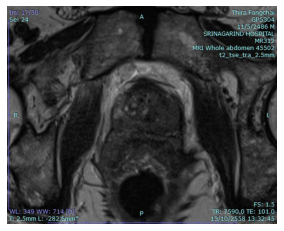

In [168]:
path_img = test_df['img_path'][1]   ## Set path/to/image
df = predict_box(path_img)
plot_img(df)

In [164]:
df

,xmin,ymin,xmax,ymax,confidence,class,name,Path,image_id
0,0.0,0.0,0.0,0.0,0.0,0,prostate,/media/tohn/SSD_ex/ProstateCancer/test/prostat...,prostate_custom_191.jpg


> #### Run : 2

B1: Postate Cancer, Confident 0.5668
B2: Postate Cancer, Confident 0.54


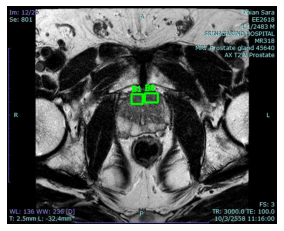

In [165]:
path_img2 = test_df['img_path'][11]  ## Set path/to/image
df2 = predict_box(path_img2)
plot_img(df2)

In [166]:
df2

,xmin,ymin,xmax,ymax,confidence,class,name,Path,image_id
0,412.625946,291.727478,449.950592,323.165771,0.566812,0,prostate,/media/tohn/SSD_ex/ProstateCancer/test/prostat...,prostate_custom_201.jpg
1,456.901031,288.853302,499.000031,318.243561,0.540099,0,prostate,/media/tohn/SSD_ex/ProstateCancer/test/prostat...,prostate_custom_201.jpg
